<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Удаление-бесполезных-столбцов" data-toc-modified-id="Удаление-бесполезных-столбцов-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Удаление бесполезных столбцов</a></span></li><li><span><a href="#Преобразование-категориальных-признаков" data-toc-modified-id="Преобразование-категориальных-признаков-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Преобразование категориальных признаков</a></span></li><li><span><a href="#Деление-на-выборки" data-toc-modified-id="Деление-на-выборки-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Деление на выборки</a></span></li><li><span><a href="#Стандартизация-данных" data-toc-modified-id="Стандартизация-данных-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Стандартизация данных</a></span></li><li><span><a href="#Проверка-данных-на-коллинеарность" data-toc-modified-id="Проверка-данных-на-коллинеарность-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Проверка данных на коллинеарность</a></span></li></ul></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

**Проблема**: из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

**Цель**: спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Построить модель с предельно большим значением *F1*-меры, большим 0.59. Дополнительно измерять *AUC-ROC*, сравнивать её значение с *F1*-мерой.

Мне предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

**План:**
1. Подготовить данные к обучению моделей
2. Исследовать баланс классов, обучить модель на несбалансированных данных
3. Сбалансировать данные разными способами, изучить поведение модели
4. Подобрать лучшую модель
5. Провести тестирование на тестовых данных

## 1. Подготовка данных

Для начала установим необходимые библиотеки

In [1]:
!pip install imbalanced-learn -q
!pip install phik -q



[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#необходимые библиотеки

import pandas as pd
import numpy as np

from imblearn.over_sampling import SMOTE, ADASYN #борьба с дисбалансом

from sklearn.metrics import f1_score, roc_auc_score, make_scorer #метрики качества моделе

from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV #вспомогательные функции для создания моделей

from sklearn.linear_model import LogisticRegression #модели
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt #графики

from sklearn.preprocessing import OneHotEncoder, StandardScaler #функции предобработки
from phik.report import correlation_report, plot_correlation_matrix

from imblearn.pipeline import Pipeline, make_pipeline

In [3]:
#считывание данных
data = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

In [4]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Итак, перед нами банковский датасет. Целевой признак - *Exited* - покинул ли клиент банк, или остался. 

Самое первое, что нужно сделать - **разделить данные** на обучающую и тестовую выборки. Валидационную использовать не планируется, так как предполагается использование кросс - валидации. 

Среди признаков явно не все пригодятся нам для прогнозирования. Так, столбцы *RowNumber*, *CustomerId*, *Surname* не относятся к нашей задаче и никак не влияют на отток клиентов(так подсказывает нам здравый смысл), поэтому их можно удалить. 

Также заметно, что не все признаки числовые, есть и категориальные, поэтому придется воспользоваться **преобразованием**. 

Затем нужно будет **стандартизировать** данные. 

Не лишним будет проверить данные на **мультиколлинеарность**. 

Также заметны **пропуски** в колонке *Tenure*, заполним их 0, так как она отвечает за количество лет, которое человек является клиентом.

### 1.1. Удаление бесполезных столбцов и заполнение пропусков

In [6]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data.Tenure = data.Tenure.fillna(0)

### 1.2. Преобразование категориальных признаков

In [7]:
ohe = OneHotEncoder(sparse=False, drop='first') #создание экземпляра кодировщика
cat_columns = data.select_dtypes('object').columns #выбор категориальных признаков из таблицы
data_ohe = ohe.fit_transform(data[cat_columns]) #осуществление преобразования
data_ohe = pd.DataFrame(data_ohe, columns=ohe.get_feature_names())
data[ohe.get_feature_names()] = data_ohe
data.drop(columns=cat_columns, inplace=True)

C:\Users\pivka\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\pivka\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### 1.3. Деление на выборки 

Для начала разделим на обучающую, валидационную и тестовую выборки.

In [8]:
features = data.drop('Exited', axis=1)
target = data['Exited']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=28)

### 1.4. Стандартизация данных 

Перед тем как применять стандартизацию, данные необходимо поделить на обучающую и тестовую выборку. Стандартизатор обучается на обучающей выборке, но применяется к обоим.

In [9]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

### 1.5. Проверка данных на коллинеарность

Построим тепловую карту корреляции признаков, чтобы отследить зависимости.

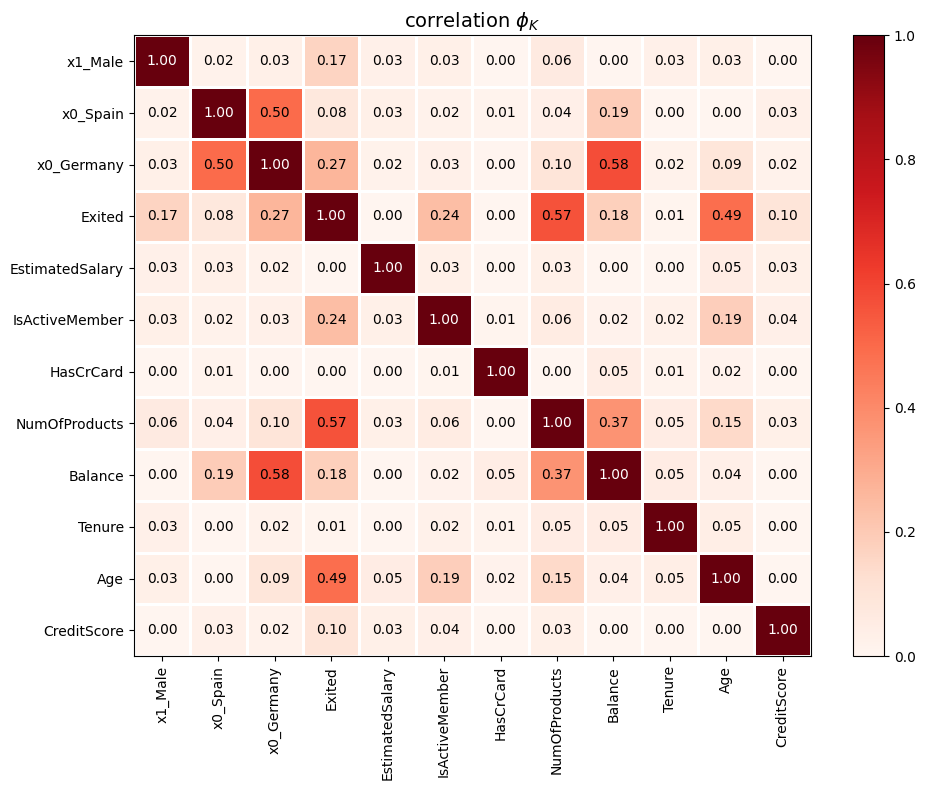

In [10]:
interval_cols = data.select_dtypes('number').columns.tolist()
phik_overview = data.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Reds", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(10, 8))

По диаграмме видно, что сильной корреляции нет ни у одной пары признаков, однако средняя коррляция есть у пар Germany, Balance и NumOfProducts, Exited. Удалять признаки не будем, так как корреляция не сильная.

### **Вывод**

Данные лишены бесполезных признаков, категориальные признаки преобразованы к количественным, данные разделены на выборки, стандартизированы и проверены на мультиколлинеарность. На этом подготовка окончена, можно приступать к проверке моделей.

## 2. Исследование задачи

Для начала определим имеется ли в нашем случае дисбаланс

In [11]:
target_train.value_counts()

0    5954
1    1546
Name: Exited, dtype: int64

1546 положительных ответов против 5954 отрицательных ответов. Отношение классов почти 1:4.

Попробуем обучить модель решающего дерева на несбалансированных данных и посморетреть на значения метрик F1 и AUC-ROC

In [12]:
model = DecisionTreeClassifier(random_state=28)
res = cross_validate(model, features_train, target_train, cv=5, scoring={"AUC": "roc_auc", "F1": make_scorer(f1_score)})
print('Среднее значние метрики F1:', res['test_F1'].mean())
print('Среднее значние метрики ROC-AUC:', res['test_AUC'].mean())

Среднее значние метрики F1: 0.5018710310217388
Среднее значние метрики ROC-AUC: 0.6881300691062489


Итак, значение метрики F1 - 0.49 и ROC-AUC - 0.68. ROC-AUC на 0.2 больше, чем у случайной модели, так что это значение не слишком плохое, но есть к чему стремиться. А вот F - мера показала маленький результат. 

## 3. Борьба с дисбалансом

Баланс классов будем настраивать на двух моделях: случаный лес и решающее дерево. Исследование будет проводится по следующим способам борьбы с дисбалансом: SMOTE, ADASYN

### 3.1. SMOTE

In [13]:
features_train_smoted, target_train_smoted = SMOTE(random_state=28).fit_resample(features_train, target_train)
print('Баланс классов после обработки:', target_train_smoted.value_counts(), sep='\n')

Баланс классов после обработки:
1    5954
0    5954
Name: Exited, dtype: int64


Обработка сравняла количество единиц и нулей в обучающей выборке, теперь классы сбалансированы. Теперь можно приступить к настройке модели решающего дерева. Для этого воспользуемся GridSearch.

In [14]:
model = DecisionTreeClassifier(random_state=28)
params = {'max_depth': range(1, 20), 'min_samples_split': range(2, 5), 'min_samples_leaf': range(2, 5)}
grid_model = GridSearchCV(model, params, cv=5, scoring=['roc_auc', 'f1'], n_jobs=-1, refit='f1')
grid_model.fit(features_train_smoted, target_train_smoted)
print('Наилучшее значение F1 достигается при глубине дерева ', grid_model.best_params_['max_depth'], ', минимальном количестве выборок для создания листа ', grid_model.best_params_['min_samples_leaf'], ' и минимальном количестве выборок для разделения ', grid_model.best_params_['min_samples_split'], sep='')

Наилучшее значение F1 достигается при глубине дерева 14, минимальном количестве выборок для создания листа 3 и минимальном количестве выборок для разделения 2


Аналогично поступим для случайного леса

In [15]:
model = RandomForestClassifier(random_state=28)
params = {'max_depth': range(1, 10), 'n_estimators': range(10, 151, 10)}
grid_model = GridSearchCV(model, params, cv=5, scoring=['roc_auc', 'f1'], n_jobs=-1, refit='f1')
grid_model.fit(features_train_smoted, target_train_smoted)
print('Наилучшее значение F1 достигается при глубине дерева ', grid_model.best_params_['max_depth'], ' и количестве деревьев ', grid_model.best_params_['n_estimators'], sep='')

Наилучшее значение F1 достигается при глубине дерева 9 и количестве деревьев 150


In [16]:
model = DecisionTreeClassifier(max_depth=16, min_samples_leaf=3, min_samples_split=2, random_state=28)
res = cross_validate(model, features_train_smoted, target_train_smoted, cv=5, scoring={"AUC": "roc_auc", "F1": make_scorer(f1_score)})
print('Среднее значние метрики F1:', res['test_F1'].mean())
print('Среднее значние метрики ROC-AUC:', res['test_AUC'].mean())


Среднее значние метрики F1: 0.8064391208861412
Среднее значние метрики ROC-AUC: 0.8643410760281924


In [17]:
model = RandomForestClassifier(max_depth=9, n_estimators=150, random_state=28)
res = cross_validate(model, features_train_smoted, target_train_smoted, cv=5, scoring={"AUC": "roc_auc", "F1": make_scorer(f1_score)})
print('Среднее значние метрики F1:', res['test_F1'].mean())
print('Среднее значние метрики ROC-AUC:', res['test_AUC'].mean())

Среднее значние метрики F1: 0.8339752355919643
Среднее значние метрики ROC-AUC: 0.9227090104357639


Получен колоссальный рост метрики F1: 0.8 для решающего дерева и 0.83 для случайного леса, ROC-AUC тоже показала положительную динамику: 0.86 для решающего дерева и 0.92 для случайного леса, что очень высоко

### 3.2. ADASYN

In [18]:
features_train_adasyned, target_train_adasyned = ADASYN(random_state=28).fit_resample(features_train, target_train)
print('Баланс классов после обработки:', target_train_smoted.value_counts(), sep='\n')

Баланс классов после обработки:
1    5954
0    5954
Name: Exited, dtype: int64


Можно заметить, что после обработки классы не выровнялись: теперь единиц стало больше, чем нулей, хоть и незначительно. Это объясняется принципом работы метода ADASYN, так как он по сути сначала уравнивает классы, как метод SMOTE, но потом добавляет еще немного точек для того, чтобы сделать данные более реалистичными. Теперь можно приступить к настройке модели решающего дерева. Для этого воспользуемся GridSearch.

In [19]:
model = DecisionTreeClassifier(random_state=28)
params = {'max_depth': range(1, 20), 'min_samples_split': range(2, 5), 'min_samples_leaf': range(2, 5)}
grid_model = GridSearchCV(model, params, cv=5, scoring=['roc_auc', 'f1'], n_jobs=-1, refit='f1')
grid_model.fit(features_train_adasyned, target_train_adasyned)
print('Наилучшее значение F1 достигается при глубине дерева ', grid_model.best_params_['max_depth'], ', минимальном количестве выборок для создания листа ', grid_model.best_params_['min_samples_leaf'], ' и минимальном количестве выборок для разделения ', grid_model.best_params_['min_samples_split'], sep='')

Наилучшее значение F1 достигается при глубине дерева 17, минимальном количестве выборок для создания листа 2 и минимальном количестве выборок для разделения 2


Аналогично поступим для случайного леса

In [20]:
model = RandomForestClassifier(random_state=28)
params = {'max_depth': range(1, 10), 'n_estimators': range(10, 151, 10)}
grid_model = GridSearchCV(model, params, cv=5, scoring=['roc_auc', 'f1'], n_jobs=-1, refit='f1')
grid_model.fit(features_train_adasyned, target_train_adasyned)
print('Наилучшее значение F1 достигается при глубине дерева ', grid_model.best_params_['max_depth'], ' и количестве деревьев ', grid_model.best_params_['n_estimators'], sep='')

Наилучшее значение F1 достигается при глубине дерева 9 и количестве деревьев 150


In [21]:
model = DecisionTreeClassifier(max_depth=18, min_samples_leaf=2, min_samples_split=2, random_state=28)
res = cross_validate(model, features_train_adasyned, target_train_adasyned, cv=5, scoring={"AUC": "roc_auc", "F1": make_scorer(f1_score)})
print('Среднее значние метрики F1:', res['test_F1'].mean())
print('Среднее значние метрики ROC-AUC:', res['test_AUC'].mean())

Среднее значние метрики F1: 0.8081393965619575
Среднее значние метрики ROC-AUC: 0.8471526462690285


In [22]:
model = RandomForestClassifier(max_depth=9, n_estimators=150, random_state=28)
res = cross_validate(model, features_train_adasyned, target_train_adasyned, cv=5, scoring={"AUC": "roc_auc", "F1": make_scorer(f1_score)})
print('Среднее значние метрики F1:', res['test_F1'].mean())
print('Среднее значние метрики ROC-AUC:', res['test_AUC'].mean())

Среднее значние метрики F1: 0.824183164123569
Среднее значние метрики ROC-AUC: 0.9056405651511831


Метрика F1 дала результат 0.81 для решающего дерева и 0.82 для случайного дерева, почти такой же, как при методе SMOTE. ROC-AUC здесь уступает аналогичной метрике для метода SMOTE всего на 0.02 и равен 0.84 для решающего дерева и 0.9 для случайного леса

### **Вывод**

Становится очевидным воздействие дисбаланса классов на работу модели: при устранении дисбаланса метрика F1 выросла более, чем в 2 раза и достигла 0.8. Вместе с ней выросла и AUC-ROC, достигнув значения 0.85. Однако принципиального отличия между методами устранения дисбаланса выявлено не было, оба способа хороша себя показали. Будем использовать SMOTE.

## 4. Подбор модели

Разобравшись с дисбалансом, можно приступать к подбору лучшей модели и её параметров. Для этой задачи будем использовать GridSearchCV.

### 4.1. Решающее дерево

В разделе 3 мы уже подобрали лучшие параметры для этой модели и получили метрику F1, равную 0.8, и ROC-AUC 0.86

In [23]:
model_tree = DecisionTreeClassifier(max_depth=18, min_samples_leaf=2, min_samples_split=2, random_state=28)

### 4.2. Случайный лес

В разделе 3 мы уже подобрали лучшие параметры для этой модели и получили метрику F1, равную 0.83 и ROC-AUC 0.92

In [24]:
model_forest = RandomForestClassifier(max_depth=9, n_estimators=150, random_state=28)

### 4.3. Логистическая регрессия

In [25]:
model_log_reg = LogisticRegression(solver='liblinear', random_state=28)
params = {'max_iter': range(10, 251, 10)}
grid_model = GridSearchCV(model_log_reg, params, cv=5, scoring=['roc_auc', 'f1'], n_jobs=-1, refit='f1')
grid_model.fit(features_train_adasyned, target_train_adasyned)
print('Наилучшее значение F1 достигается при макисмальном количестве итераций', grid_model.best_params_['max_iter'])

Наилучшее значение F1 достигается при макисмальном количестве итераций 10


In [26]:
model_log_reg = LogisticRegression(max_iter=10, solver='liblinear', random_state=28)
res = cross_validate(model_log_reg, features_train_adasyned, target_train_adasyned, cv=5, scoring={"AUC": "roc_auc", "F1": make_scorer(f1_score)})
print('Среднее значние метрики F1:', res['test_F1'].mean())
print('Среднее значние метрики ROC-AUC:', res['test_AUC'].mean())

Среднее значние метрики F1: 0.6902069055650493
Среднее значние метрики ROC-AUC: 0.7424082496806708


Для логистической регрессии получены маленькие значения обоих метрик: F1 равна 0.69, AUC-ROC достигает 0.74. Это самый низкий результат среди всех рассмотренных моделей. 

### **Вывод**

Самый лучший результат показала модель случайного леса, ее будем использовать на тестовой выборке.

## 5. Тестирование модели на тестовых данных

In [27]:
model = RandomForestClassifier(max_depth=9, n_estimators=150, random_state=28)
model.fit(features_train_adasyned, target_train_adasyned)
predictions = model.predict(features_test)
res = f1_score(predictions, target_test)
roc = roc_auc_score(predictions, target_test)
print('Значение F1:', res)
print('Значение ROC_AUC:', roc)

Значение F1: 0.5980707395498392
Значение ROC_AUC: 0.7129535663869992


Победа! Удалось достигнуть требуемой точности: F1 равна 0.598, ROC-AUC равна 0.71. В целом результат достаточно неплохой, ROC-AUC больше на 0.2, чем у случайной модели. AUC-ROC показывает наскольок точно модель предсказывает класс, то есть в нашем случае модель с вероятность 0.71 угадает класс объекта - приличная точность.